lets activate Autoreload in order to all changed code before any execution

In [3]:
%reload_ext autoreload
%autoreload 2

# Lets imoprt all the libraries we need

In [118]:
# ---------------------------------- Models ---------------------------------- #
from darts.models import TFTModel
import torch

# ---------------------------------- Tabular --------------------------------- #
import pandas as pd
import numpy as np

# ----------------------------------- Utils ---------------------------------- #
from darts import TimeSeries
import matplotlib.pyplot as plt

In [24]:
# check if working in colab
try:
    # In colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/projects/paris-traffic-forecast
    %pip install -q darts

except:
    # In local
    A = %pwd
    if A.split('/')[-1] == "notebooks":
        %cd ..
%pwd

'/mnt/c/Users/Mustapha/Documents/competitions/BCG_Gamma/paris-traffic-forecast'

## Needs

Prior to executing this notebook you should have your data in the data folder, please execute the bash script `data_src/get_data.sh` to download the data.

In [47]:
# !./data_src/get_data.sh

# Get data

In [148]:
data_paths = ["data/AV_Champs_Elysees.csv", "data/Convention.csv", "data/Sts_Peres.csv"]
time_col = "Date et heure de comptage"
input_cols = ["Date et heure de comptage"]
output_cols = ["Débit horaire", "Taux d'occupation"]

df = pd.read_csv(data_paths[0], sep=";").sort_values(time_col)
# print("all data :")
# display(df.head(2))
print("Important data :")
display(df[input_cols+output_cols].head())

Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan
Important data :


,Date et heure de comptage,Débit horaire,Taux d'occupation
4253,2020-11-01T04:00:00+01:00,34.0,0.40111
4258,2020-11-01T05:00:00+01:00,40.0,0.48389
3155,2020-11-01T06:00:00+01:00,66.0,0.75056
3535,2020-11-01T07:00:00+01:00,108.0,0.99611
4251,2020-11-01T08:00:00+01:00,126.0,1.09889


Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


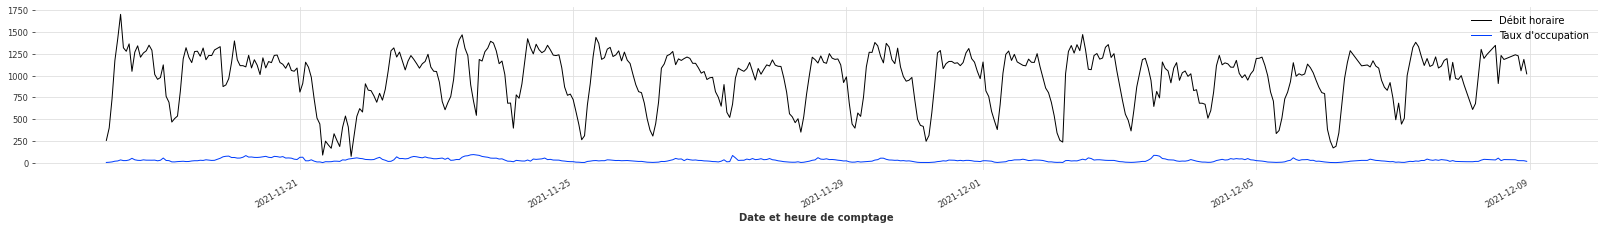

In [210]:
# ------------------------------ Other approach ------------------------------ #
# X = pd.DatetimeIndex(pd.to_datetime(df['Date et heure de comptage'], utc=True).dt.tz_localize(None))
# Y = df[output_cols]

# ---------------------------- Nouamane's approach --------------------------- #
new_df = df.copy()
new_df[time_col] = pd.to_datetime(df[time_col], utc=True).dt.tz_localize(None)
new_df[time_col] = pd.DatetimeIndex(new_df[time_col])
new_df = new_df.set_index(time_col)

ts = TimeSeries.from_dataframe(new_df, 
                          value_cols=output_cols,
                          fill_missing_dates=True,
                          freq='H')

# ------------------------------ Missing values ------------------------------ #
print("Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan")
ts._xa.values = pd.DataFrame(ts.values()).interpolate().to_numpy().reshape((-1, len(output_cols), 1)) #Not the most intuitive way to do it, but it works with one line of code :D
# ---------------------------------- Ploting --------------------------------- #
# fig, _ = plt.subplots(figsize=(28, 4))
# ts[-900:].plot(lw=1, figure = fig)
plt.figure(figsize=(28, 3))
ts[-500:].plot(lw=1)

# Model testing

In [57]:
model = TFTModel()